1. Valores faltantes por columna:
exportaciones      0
importaciones      0
saldo_comercial    0
   Total faltantes: 0

2. Filas inconsistentes (|saldo_comercial - (exportaciones - importaciones)| > 0.01): 0
   No se detectaron discrepancias relevantes.

3. Estadísticas descriptivas:
                 count      mean       std       min      25%     50%       75%      max
exportaciones     76.0  2748.671  3898.286    64.736  169.568  760.05  3269.050  13924.2
importaciones     76.0  2568.110  3570.001    55.842  152.366  734.50  2569.619  11895.8
saldo_comercial   76.0   180.561   831.070 -1305.100 -131.200   15.40   169.400   3401.0

4. Mayores aumentos porcentuales en exportaciones:
año
1974    113.59
2000     84.51
1995     83.11
1998     78.85
1951     60.08
   Mayores caídas porcentuales en exportaciones:
año
2001   -47.83
1999   -38.23
1996   -37.08
1958   -33.72
2015   -31.54



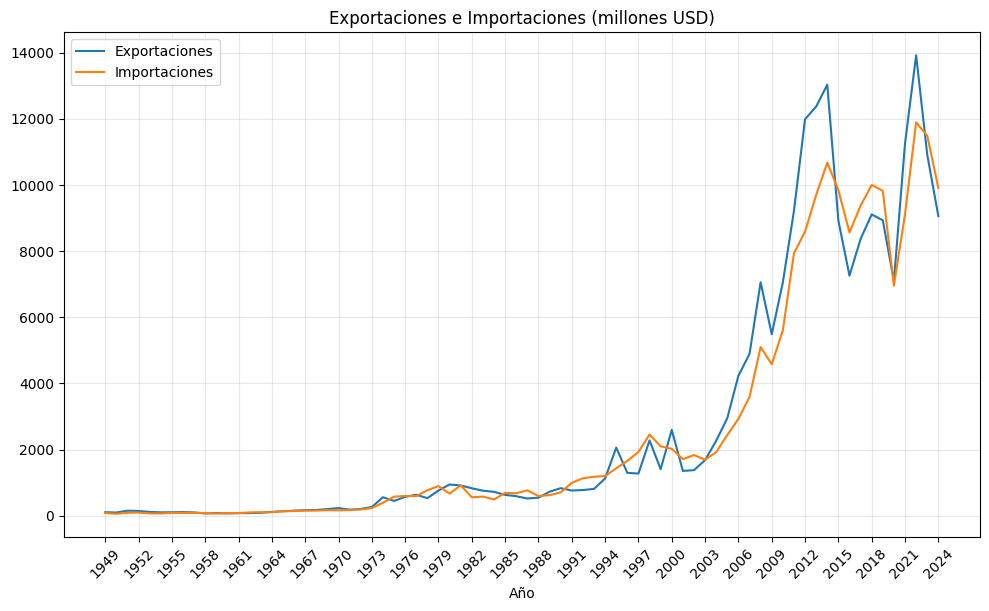

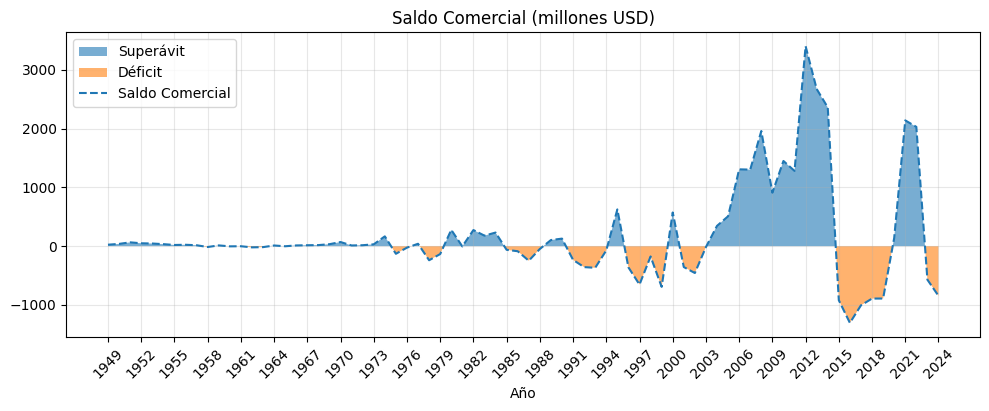

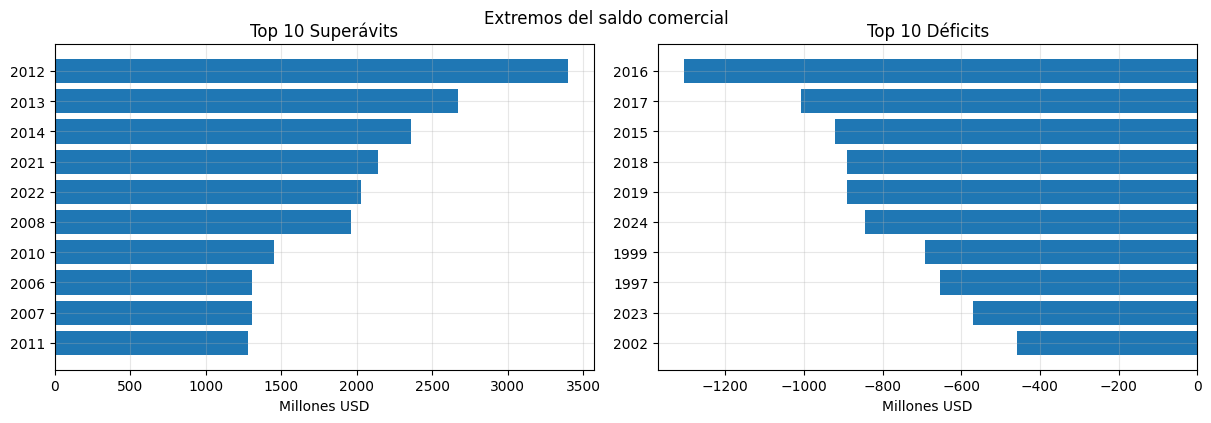

In [9]:
import sqlite3
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from func_auxiliares.config import DB_PATH

# === configuraciones === 
DISCREPANCY_TOL = 0.01  # millones USD

# === cargar datos ===
with sqlite3.connect(str(DB_PATH)) as conn:
    df = pd.read_sql(
        "SELECT año, exportaciones, importaciones, saldo_comercial FROM balanza_comercial",
        conn
    )

# === ordenar y tipar ===
df["año"] = df["año"].astype(int)
df = df.sort_values("año").set_index("año")

# === faltantes ===
missing_counts = df.isna().sum()
total_missing = missing_counts.sum()
print("1. Valores faltantes por columna:")
print(missing_counts.to_string())
print(f"   Total faltantes: {total_missing}\n")

# === consistencia ===
df["balance_calc"] = df["exportaciones"] - df["importaciones"]
df["diff"] = df["saldo_comercial"] - df["balance_calc"]
inconsistent = df[df["diff"].abs() > DISCREPANCY_TOL]
print(f"2. Filas inconsistentes (|saldo_comercial - (exportaciones - importaciones)| > {DISCREPANCY_TOL}): {len(inconsistent)}")
if not inconsistent.empty:
    print(inconsistent[["exportaciones", "importaciones", "saldo_comercial", "balance_calc", "diff"]].round(4))
else:
    print("   No se detectaron discrepancias relevantes.\n")

# === estadísticas descriptivas ===
desc = df[["exportaciones", "importaciones", "saldo_comercial"]].describe().T
desc["cv_%"] = (desc["std"] / desc["mean"]) * 100
print("3. Estadísticas descriptivas:")
print(desc[["count", "mean", "std", "min", "25%", "50%", "75%", "max"]].round(3).to_string())
print()

# === crecimiento porcentual anual ===
for col in ["exportaciones", "importaciones", "saldo_comercial"]:
    df[f"{col}_gr_%"] = df[col].pct_change() * 100

print("4. Mayores aumentos porcentuales en exportaciones:")
print(df["exportaciones_gr_%"].dropna().sort_values(ascending=False).head(5).round(2).to_string())
print("   Mayores caídas porcentuales en exportaciones:")
print(df["exportaciones_gr_%"].dropna().sort_values().head(5).round(2).to_string())
print()

# === visualizaciones ===

# Serie temporal: exportaciones e importaciones
plt.figure(figsize=(10, 6))
plt.plot(df.index, df["exportaciones"], label="Exportaciones", linewidth=1.5)
plt.plot(df.index, df["importaciones"], label="Importaciones", linewidth=1.5)
plt.title("Exportaciones e Importaciones (millones USD)")
plt.legend()
plt.grid(alpha=0.3)
plt.xlabel("Año")
plt.tight_layout()
plt.xticks(df.index[::3], rotation=45)
plt.show()
plt.close()

# Saldo comercial con área (superávit vs déficit)
plt.figure(figsize=(10, 4))
tb = df["saldo_comercial"]
plt.fill_between(df.index, tb, 0, where=tb >= 0, interpolate=True, alpha=0.6, label="Superávit")
plt.fill_between(df.index, tb, 0, where=tb < 0, interpolate=True, alpha=0.6, label="Déficit")
plt.plot(df.index, tb, linestyle="--", label="Saldo Comercial")
plt.title("Saldo Comercial (millones USD)")
plt.legend()
plt.grid(alpha=0.3)
plt.xlabel("Año")
plt.tight_layout()
plt.xticks(df.index[::3], rotation=45)
plt.show()
plt.close()

# Top 10 superávits y déficits
top_surplus = df["saldo_comercial"].sort_values(ascending=False).head(10)
top_deficit = df["saldo_comercial"].sort_values().head(10)
fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
axes[0].barh(top_surplus.index.astype(str), top_surplus.values)
axes[0].invert_yaxis()
axes[0].set_title("Top 10 Superávits")
axes[0].set_xlabel("Millones USD")
axes[0].grid(alpha=0.3)
axes[1].barh(top_deficit.index.astype(str), top_deficit.values)
axes[1].invert_yaxis()
axes[1].set_title("Top 10 Déficits")
axes[1].set_xlabel("Millones USD")
axes[1].grid(alpha=0.3)
fig.suptitle("Extremos del saldo comercial", y=1.02)

plt.show()
plt.close()


